In [8]:
import os
import re
import numpy as np
import pandas as pd
import sklearn
from sklearn.utils import shuffle

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')


from scipy.sparse import csr_matrix
from collections import Counter
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.utils import class_weight


#!pip install imbalanced-learn
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/saumyamehta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/saumyamehta/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:
olid_data = pd.read_csv("data/OLIDv1/olid-training-v1.0.tsv", sep='\t')


In [10]:
def preprocess(sent, lemmatizer, stop_words):
    
    alphabet = "abcdefghijklmnopqrstuvwxyz 0123456789',."
    sent = sent.lower()
    sent = sent.replace('@user','')
    sent = sent.replace('@[\w\-]+','')

    cleaned_sent_list = [char if char in alphabet else ' ' for char in sent] # remove all tags not in the alphabet

    cleaned_sent = ''.join(cleaned_sent_list)
    cleaned_sent_list = [lemmatizer.lemmatize(token) for token in cleaned_sent.split(" ")]
    cleaned_sent_list = [word for word in cleaned_sent_list if not word in stop_words]
    cleaned_sent = ' '.join(cleaned_sent_list)
    cleaned_sent = cleaned_sent.replace("n't",' not') # replace words like "isn't" with "is not"
    cleaned_sent = ' . '.join([x for x in cleaned_sent.split('.') if len(x)>0]) # remove multiple periods, and add spaces before and after a period
    cleaned_sent = ' , '.join([x for x in cleaned_sent.split(',') if len(x)>0]) # add spaces before and after a comma
    cleaned_sent = ' '.join(cleaned_sent.split()) # remove multiple spaces
    return cleaned_sent

In [20]:
X_train = olid_data.tweet
y_train = olid_data.subtask_b

X_train = X_train[y_train.notna()]
y_train = y_train[y_train.notna()]
X_test=pd.read_csv('data/OLIDv1/testset-levelb.tsv',sep="\t").tweet
y_test=pd.read_csv( 'data/OLIDv1/labels-levelb.csv',header=None).iloc[:,-1]
y_test = pd.factorize(y_test)[0]
y_train = pd.factorize(y_train)[0]

import collections
collections.Counter(y_train)
print(f'X train shape: {X_train.shape}, y train shape: {y_train.shape}')
collections.Counter(y_train)


X train shape: (4400,), y train shape: (4400,)


Counter({0: 524, 1: 3876})

Splitting data into train, test and hold out sets.
Our split will be 80% train, 10% validation and 10% test

In [21]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train,test_size=0.2, random_state=42)
# check shapes of train, test and validation data
print(f'X train shape: {X_train.shape}, y train shape: {y_train.shape}')
print(f'X valid shape: {X_valid.shape}, y valid shape: {y_valid.shape}')
print(f'X valid shape: {X_test.shape}, y test shape: {y_test.shape}')


X train shape: (3520,), y train shape: (3520,)
X valid shape: (880,), y valid shape: (880,)
X valid shape: (240,), y test shape: (240,)


Data preprocessing. 

In [22]:

stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()
data_train = [preprocess(tweet,lemmatizer,stop_words) for tweet in X_train]
data_valid = [preprocess(tweet,lemmatizer,stop_words) for tweet in X_valid]
data_test = [preprocess(tweet,lemmatizer,stop_words) for tweet in X_test]

In [23]:
data_train[0], data_valid[0], data_test[0]

('oh england view gun control stopped mattering 1776',
 'fucking delusional',
 'whoisq wherestheserver dumpnike declasfisa democrat support antifa , muslim brotherhood , ms13 , isis , pedophilia , child trafficking , taxpayer funded abortion s , election fraud , sedition treason lockthemallup wwg1wga qanon url')

Create a vocabulary with UNK token for out of vocabulary words

In [24]:
vocab_size = 10000
embedding_size = 100
lstm_output_dim = 32
max_length = 200
trunc_type='post'
padding_type='post'
oov_tok = "<UNK>"

Tokenisation and padding for sentences


In [25]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(data_train)


In [26]:
train_sequences = tokenizer.texts_to_sequences(data_train)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

valid_sequences = tokenizer.texts_to_sequences(data_valid)
valid_padded = pad_sequences(valid_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)



# Building the model

RNN architecture: Embedding layer of size 100 -> lstm layer with output of 32 dimension -> linear layer activated by relu -> softmax to get probability 

In [27]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=vocab_size,output_dim=embedding_size,input_length=max_length))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences = True)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(30, return_sequences = True)))
model.add(tf.keras.layers.GlobalMaxPool1D())
model.add(tf.keras.layers.Dense(100, activation="relu"))
model.add(tf.keras.layers.Dense(20, activation="relu"))
model.add(tf.keras.layers.Dropout(0.05))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [39]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 100)          1000000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200, 128)          84480     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 200, 60)           38160     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 60)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               6100      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                2020      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)               

In [28]:
# compute class weights : "https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html"
class_weights = class_weight.compute_class_weight(
    class_weight = 'balanced',
    classes = np.unique(y_train),
    y = y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))
class_weights


{0: 4.271844660194175, 1: 0.5662805662805663}

In [29]:
# Training loop and early stopping 

callbacks = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",mode="auto", patience=5,restore_best_weights=True )
n_epochs = 15

In [30]:
model_trained = model.fit(train_padded, y_train, batch_size=128, epochs = n_epochs, 
verbose=2, class_weight=class_weights,validation_data=(valid_padded, y_valid), callbacks = [callbacks])

2021-12-08 13:41:49.885934: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-08 13:41:49.886174: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
Epoch 1/15
28/28 - 10s - loss: 0.6932 - accuracy: 0.8080 - val_loss: 0.6880 - val_accuracy: 0.7284
Epoch 2/15
28/28 - 8s - loss: 0.6692 - accuracy: 0.7080 - val_loss: 0.6662 - val_accuracy: 0.5580
Epoch 3/15
28/28 - 7s - loss: 0.4428 - accuracy: 0.7761 - val_loss: 0.5217 - val_accuracy: 0.7534
Epoch 4/15
28/28 - 7s - loss: 0.2468 - accuracy: 0.8955 - val_loss: 0.5222 - val_accuracy: 0.7750
Epoch 5/15
28/28 - 7s - loss: 0.1600 - accuracy: 0.9310 - val_loss: 0.8905 - val_accuracy: 0.7057
Epoch 6/15
28/28 - 7s - loss: 0.1102 - accuracy: 0.9565 - val_loss: 0.7627 - val_accuracy: 0.7864
Epoch 7/15
28/28 - 7s - loss: 0.0864 - accuracy: 0.9747 - val_loss: 0.7977 - val_accuracy: 0.7989
Epoch 8/15
28/28 - 9s - loss: 0.0577

In [31]:
model_trained.history

{'loss': [0.6932268738746643,
  0.6691521406173706,
  0.44284284114837646,
  0.24684980511665344,
  0.15997947752475739,
  0.11015845090150833,
  0.0864207074046135,
  0.05770605430006981],
 'accuracy': [0.8079545497894287,
  0.7079545259475708,
  0.7761363387107849,
  0.8954545259475708,
  0.9309659004211426,
  0.9565340876579285,
  0.9747158885002136,
  0.980681836605072],
 'val_loss': [0.6880216002464294,
  0.6661931872367859,
  0.521664023399353,
  0.5221653580665588,
  0.890513002872467,
  0.7626919746398926,
  0.7976592779159546,
  0.9257216453552246],
 'val_accuracy': [0.7284091114997864,
  0.5579545497894287,
  0.7534090876579285,
  0.7749999761581421,
  0.7056818008422852,
  0.7863636612892151,
  0.7988636493682861,
  0.7613636255264282]}

Text(0, 0.5, 'Accuracy')

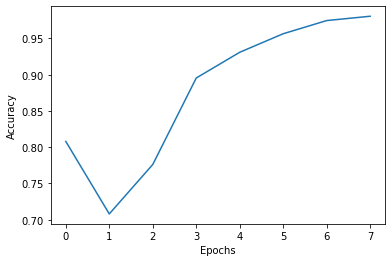

In [32]:
# PLotting accuracy of train
import matplotlib.pyplot as plt
plt.plot(model_trained.history['accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


Text(0, 0.5, 'Validation Accuracy')

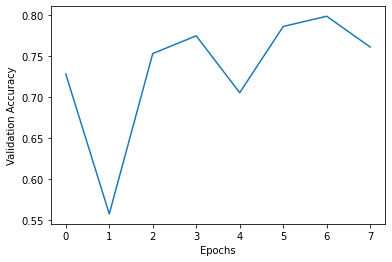

In [36]:
# PLotting accuracy of train
import matplotlib.pyplot as plt
plt.plot(model_trained.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')

In [37]:
test_sequences = tokenizer.texts_to_sequences(data_test)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.evaluate(test_padded,y_test))


8/8 [==============================] - 0s 29ms/step - loss: 2.0215 - accuracy: 0.2208
[2.021509885787964, 0.22083333134651184]


In [38]:
from sklearn.metrics import classification_report

y_pred = model.predict(test_padded, batch_size=128, verbose=1)
y_pred = (y_pred>0.5)
print(classification_report(y_test, y_pred))

2/2 [==============================] - 0s 70ms/step
              precision    recall  f1-score   support

           0       0.75      0.18      0.29       213
           1       0.07      0.52      0.13        27

    accuracy                           0.22       240
   macro avg       0.41      0.35      0.21       240
weighted avg       0.67      0.22      0.28       240

